#--- 1. Подключение библиотек в python -----------------------------

Импортируем библиотеки и создаём соединение с SQLite in-memory базой, где будем хранить наши таблицы.

In [32]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
# фиксируем seed для воспроизводимости
np.random.seed(42)

In [33]:
# --- 1. Создаём соединение с SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()



# --- 2. Генерация данных -----------------------------


Создаём тестовые данные для анализа:

номенклатуру товаров,

клиентов и их менеджеров,

команды менеджеров (team leads),

заказы (корзину), продажи, возвраты,

плановые показатели.

Для чего: Моделируем реальные бизнес-данные для последующего анализа и визуализации.

In [74]:
# Номенклатура
nomenclature = pd.DataFrame({
    'article': ['A1', 'A2', 'A3', 'A4', 'A5', 'S1', 'T1', 'L1', 'H1', 'F1'],
    'category': ['Books', 'Books', 'Audio', 'Audio', 'Ebook', 'Smartphone', 'TV', 'Laptop', 'Headphones', 'Flash'],
    'price': [500, 300, 800, 600, 450, 20000, 40000, 35000, 5000, 1500]
})
nomenclature


,article,category,price
0,A1,Books,500
1,A2,Books,300
2,A3,Audio,800
3,A4,Audio,600
4,A5,Ebook,450
5,S1,Smartphone,20000
6,T1,TV,40000
7,L1,Laptop,35000
8,H1,Headphones,5000
9,F1,Flash,1500


In [75]:
# Клиенты
clients = pd.DataFrame({
    'client_id': range(1, 6),
    'name': ['ООО Альфа', 'ООО Бета', 'ООО Гамма', 'ООО Дельта', 'ООО Омега'],
    'inn': ['111111', '222222', '333333', '444444', '555555'],
    'manager_id': [1, 2, 3, 4, 5]
})
clients

,client_id,name,inn,manager_id
0,1,ООО Альфа,111111,1
1,2,ООО Бета,222222,2
2,3,ООО Гамма,333333,3
3,4,ООО Дельта,444444,4
4,5,ООО Омега,555555,5


In [76]:
# Менеджеры и команды (2 team leads)
teams = pd.DataFrame({
    'manager_id': [1, 2, 3, 4, 5],
    'team_lead_id': [10, 10, 11, 11, 11],
    'role': ['manager']*5
})
teams

,manager_id,team_lead_id,role
0,1,10,manager
1,2,10,manager
2,3,11,manager
3,4,11,manager
4,5,11,manager


In [77]:
# Заказы (корзина)
orders = pd.DataFrame({
    'client_id': np.random.choice(range(1, 6), 20),
    'article': np.random.choice(nomenclature['article'], 20),
    'sum_article': np.random.randint(200, 1000, 20),
    'margin_article': np.random.randint(50, 300, 20)
})
orders

,client_id,article,sum_article,margin_article
0,4,F1,976,103
1,5,S1,545,270
2,3,H1,764,240
3,5,A1,539,195
4,5,F1,291,267
5,2,A3,566,93
6,3,T1,654,211
7,3,A4,627,251
8,3,H1,708,239
9,5,A3,975,277


In [78]:
# Реализации (продажи)
sales = pd.DataFrame({
    'client_id': np.random.choice(range(1, 6), 25),
    'article': np.random.choice(nomenclature['article'], 25),
    'sale_sum': np.random.randint(300, 1500, 25)
})
sales

,client_id,article,sale_sum
0,5,A5,802
1,5,F1,1066
2,2,T1,697
3,5,F1,1170
4,2,H1,1094
5,1,T1,692
6,4,H1,506
7,4,L1,1338
8,4,A2,1191
9,5,A1,1163


In [79]:
# Возвраты
returns = pd.DataFrame({
    'client_id': np.random.choice(range(1, 6), 8),
    'article': np.random.choice(nomenclature['article'], 8),
    'return_sum': np.random.randint(50, 300, 8)
})
returns

,client_id,article,return_sum
0,5,F1,165
1,1,T1,254
2,5,H1,282
3,4,T1,52
4,4,A1,152
5,4,A1,247
6,4,H1,249
7,4,H1,204


In [80]:
# Плановые показатели
plan_metrics = pd.DataFrame({
    'manager_id': [1, 2, 3, 4, 5],
    'period': ['2025-10'] * 5,
    'plan_revenue': [5000, 7000, 6000, 6500, 5500],
    'plan_margin': [1500, 2000, 1800, 1700, 1600]
})
plan_metrics

,manager_id,period,plan_revenue,plan_margin
0,1,2025-10,5000,1500
1,2,2025-10,7000,2000
2,3,2025-10,6000,1800
3,4,2025-10,6500,1700
4,5,2025-10,5500,1600


Ключевые связи в БД: \
clients.manager_id → managers.id \
orders.client_id → clients.client_id \
sales.client_id → clients.client_id \
returns.client_id → clients.client_id \
orders.article → nomenclature.article \
sales.article → nomenclature.article \
returns.article → nomenclature.article

# --- 3. Запись всех таблиц в SQLite

In [81]:
# моделируем работу с БД через sqlite3, для этого запишем наши данные в sql формат
tables = {
    'nomenclature': nomenclature,
    'clients': clients,
    'teams': teams,
    'orders': orders,
    'sales': sales,
    'returns': returns,
    'plan_metrics': plan_metrics
}

for name, df in tables.items():
    df.to_sql(name, conn, index=False, if_exists='replace')

# --- 4. SQL-запрос с расчётом основных метрик для менеджеров----------------

4. Расчёт метрик для менеджеров

Создаём сводные данные по каждой продаже — берём таблицу продаж и соединяем её с таблицами:

returns — чтобы учесть возвраты,

orders — чтобы получить маржу по каждой позиции,

clients — чтобы знать, какой менеджер отвечает за клиента,

nomenclature — чтобы знать категорию товара.

Вычисляем ключевые показатели по каждой строке факта:

Чистая выручка = сумма продаж минус сумма возвратов для конкретного клиента и товара.

Маржа = сумма маржи по позициям.

Группируем данные по менеджеру, клиенту, категории и товару, чтобы правильно агрегировать и не дублировать строки.

Делаем итоговую агрегацию по менеджеру и категории:

Суммируем выручку и маржу по всем клиентам менеджера в каждой категории.

Считаем количество уникальных клиентов у менеджера.

Рассчитываем средний чек на одного клиента = выручка / количество клиентов.

В итоге получаем ключевые показатели эффективности каждого менеджера и по категориям товаров.

In [82]:
query = """
WITH fact_sales AS (
    SELECT
        s.client_id,
        c.manager_id,
        n.category,
        s.article,
        SUM(s.sale_sum) - COALESCE(SUM(r.return_sum), 0) AS revenue,
        SUM(o.margin_article) AS margin
    FROM sales s
    LEFT JOIN returns r ON s.article = r.article AND s.client_id = r.client_id
    LEFT JOIN orders o ON o.article = s.article AND o.client_id = s.client_id
    LEFT JOIN clients c ON s.client_id = c.client_id
    LEFT JOIN nomenclature n ON s.article = n.article
    GROUP BY s.client_id, c.manager_id, n.category, s.article
)
SELECT
    f.manager_id,
    f.category,
    SUM(f.revenue) AS revenue_fact,
    SUM(f.margin) AS margin_fact,
    COUNT(DISTINCT f.client_id) AS clients_count,
    ROUND(SUM(f.revenue) / NULLIF(COUNT(DISTINCT f.client_id), 0), 2) AS avg_check
FROM fact_sales f
GROUP BY f.manager_id, f.category
ORDER BY f.manager_id, f.category;
"""

df_metrics = pd.read_sql(query, conn)

# Агрегация по план/факт
query_plan_fact = """
SELECT
    f.manager_id,
    SUM(f.revenue_fact) AS revenue_fact,
    SUM(f.margin_fact) AS margin_fact,
    p.plan_revenue,
    p.plan_margin,
    ROUND(SUM(f.revenue_fact) / p.plan_revenue, 2) AS revenue_progress,
    ROUND(SUM(f.margin_fact) / p.plan_margin, 2) AS margin_progress
FROM (
    SELECT
        c.manager_id,
        SUM(s.sale_sum) - COALESCE(SUM(r.return_sum), 0) AS revenue_fact,
        SUM(o.margin_article) AS margin_fact
    FROM sales s
    LEFT JOIN returns r ON s.article = r.article AND s.client_id = r.client_id
    LEFT JOIN orders o ON o.article = s.article AND o.client_id = s.client_id
    LEFT JOIN clients c ON s.client_id = c.client_id
    GROUP BY c.manager_id
) f
LEFT JOIN plan_metrics p ON f.manager_id = p.manager_id
GROUP BY f.manager_id;
"""

df_plan_fact = pd.read_sql(query_plan_fact, conn)

# --- 5. SQL-запрос с расчётом основных метрик для руководителей

Аналогично предыдущему запросу считаем показатели для каждого руководителя.

In [83]:
query_tl =  """
WITH fact_sales AS (
    SELECT
        s.client_id,
        t.team_lead_id,
        n.category,
        s.article,
        SUM(s.sale_sum) - COALESCE(SUM(r.return_sum), 0) AS revenue,
        SUM(o.margin_article) AS margin
    FROM sales s
    LEFT JOIN returns r ON s.article = r.article AND s.client_id = r.client_id
    LEFT JOIN orders o ON o.article = s.article AND o.client_id = s.client_id
    LEFT JOIN clients c ON s.client_id = c.client_id
    LEFT JOIN teams t ON c.manager_id = t.manager_id
    LEFT JOIN nomenclature n ON s.article = n.article
    GROUP BY s.client_id, t.team_lead_id, n.category, s.article
)
SELECT
    f.team_lead_id,
    f.category,
    SUM(f.revenue) AS revenue_fact,
    SUM(f.margin) AS margin_fact,
    COUNT(DISTINCT f.client_id) AS clients_count,
    ROUND(SUM(f.revenue) / NULLIF(COUNT(DISTINCT f.client_id), 0), 2) AS avg_check
FROM fact_sales f
GROUP BY f.team_lead_id, f.category
ORDER BY f.team_lead_id, f.category;
"""

df_metrics_tl = pd.read_sql(query_tl, conn)

# Агрегация по план/факт
query_plan_fact_tl = """
WITH fact_data AS (
    SELECT
        t.team_lead_id,
        SUM(s.sale_sum) - COALESCE(SUM(r.return_sum), 0) AS revenue_fact,
        SUM(o.margin_article) AS margin_fact
    FROM sales s
    LEFT JOIN returns r ON s.article = r.article AND s.client_id = r.client_id
    LEFT JOIN orders o ON o.article = s.article AND o.client_id = s.client_id
    LEFT JOIN clients c ON s.client_id = c.client_id
    LEFT JOIN teams t ON c.manager_id = t.manager_id
    GROUP BY t.team_lead_id
),
plan_data AS (
    SELECT
        t.team_lead_id,
        SUM(p.plan_revenue) AS plan_revenue,
        SUM(p.plan_margin) AS plan_margin
    FROM plan_metrics p
    JOIN teams t ON p.manager_id = t.manager_id
    GROUP BY t.team_lead_id
)
SELECT
    f.team_lead_id,
    f.revenue_fact,
    f.margin_fact,
    p.plan_revenue,
    p.plan_margin,
    ROUND(f.revenue_fact / NULLIF(p.plan_revenue, 0), 2) AS revenue_progress,
    ROUND(f.margin_fact / NULLIF(p.plan_margin, 0), 2) AS margin_progress
FROM fact_data f
LEFT JOIN plan_data p ON f.team_lead_id = p.team_lead_id
ORDER BY f.team_lead_id;
"""

df_plan_fact_tl = pd.read_sql(query_plan_fact_tl, conn)
df_dash = pd.merge(df_metrics_tl, df_plan_fact_tl, on='team_lead_id', how='left')

# --- 6. Дашборд для менеджеров (в seaborn) -----------------------------

Строим графики для визуализации:

Выручка по категориям и менеджерам.

Выполнение плана по выручке.

Средний чек по категориям.

Связь выручки и маржи.

/tmp/ipython-input-1092631464.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-1092631464.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha='right', fontsize=10)
/tmp/ipython-input-1092631464.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-1092631464.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-1092631464.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45, ha='right', fontsize=10)


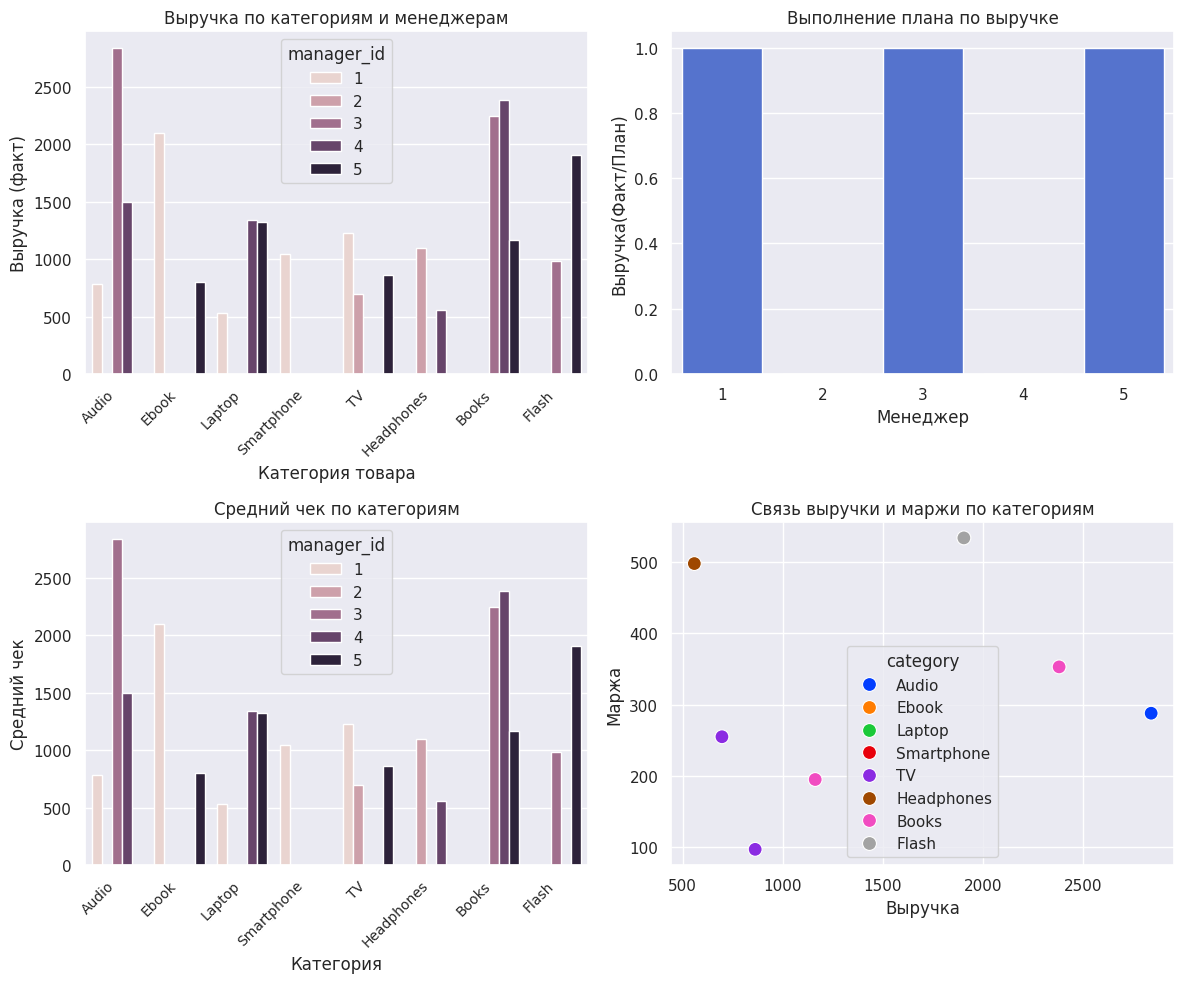

In [88]:
# Создаем фигуру 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Выручка по категориям
sns.barplot(
    data=df_metrics,
    x='category',
    y='revenue_fact',
    hue='manager_id',
    ci=None,
    ax=axes[0,0]
)
axes[0,0].set_title("Выручка по категориям и менеджерам")
axes[0,0].set_xlabel("Категория товара")
axes[0,0].set_ylabel("Выручка (факт)")
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha='right', fontsize=10)

# 2. Выполнение плана по выручке
sns.barplot(
    data=df_plan_fact,
    x='manager_id',
    y='revenue_progress',
    ci=None,
    ax=axes[0,1],
    color='royalblue'
)
axes[0,1].set_title("Выполнение плана по выручке")
axes[0,1].set_xlabel("Менеджер")
axes[0,1].set_ylabel("Выручка(Факт/План)")

# 3. Средний чек по категориям
sns.barplot(
    data=df_metrics,
    x='category',
    y='avg_check',
    hue='manager_id',
    ci=None,
    ax=axes[1,0]
)
axes[1,0].set_title("Средний чек по категориям")
axes[1,0].set_xlabel("Категория")
axes[1,0].set_ylabel("Средний чек")
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45, ha='right', fontsize=10)

# 4. Корреляция выручка vs маржа
sns.scatterplot(
    data=df_metrics,
    x='revenue_fact',
    y='margin_fact',
    hue='category',
    s=100,
    ax=axes[1,1]
)
axes[1,1].set_title("Связь выручки и маржи по категориям")
axes[1,1].set_xlabel("Выручка")
axes[1,1].set_ylabel("Маржа")

# Подгоняем layout
plt.tight_layout()
plt.show()

# --- 7. Дашборд для руководителей (в seaborn) -----------------------------

Строим графики для руководителей команд:

Выручка и маржа План/Факт.

Средний чек на клиента.

Выручка по категориям товаров.

In [85]:
df_dash

,team_lead_id,category,revenue_fact_x,margin_fact_x,clients_count,avg_check,revenue_fact_y,margin_fact_y,plan_revenue,plan_margin,revenue_progress,margin_progress
0,10,Audio,784,NaN,1,784.0,7475,255,12000,3500,0.0,0.0
1,10,Ebook,2096,NaN,1,2096.0,7475,255,12000,3500,0.0,0.0
2,10,Headphones,1094,NaN,1,1094.0,7475,255,12000,3500,0.0,0.0
3,10,Laptop,530,NaN,1,530.0,7475,255,12000,3500,0.0,0.0
4,10,Smartphone,1048,NaN,1,1048.0,7475,255,12000,3500,0.0,0.0
5,10,TV,1923,255.0,2,961.0,7475,255,12000,3500,0.0,0.0
6,11,Audio,4336,288.0,2,2168.0,17899,1965,18000,5100,0.0,0.0
7,11,Books,5794,548.0,3,1931.0,17899,1965,18000,5100,0.0,0.0
8,11,Ebook,802,NaN,1,802.0,17899,1965,18000,5100,0.0,0.0
9,11,Flash,2887,534.0,2,1443.0,17899,1965,18000,5100,0.0,0.0


/tmp/ipython-input-347105256.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-347105256.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-347105256.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-347105256.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-347105256.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-347105256.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-347105256.py:68: FutureWarni

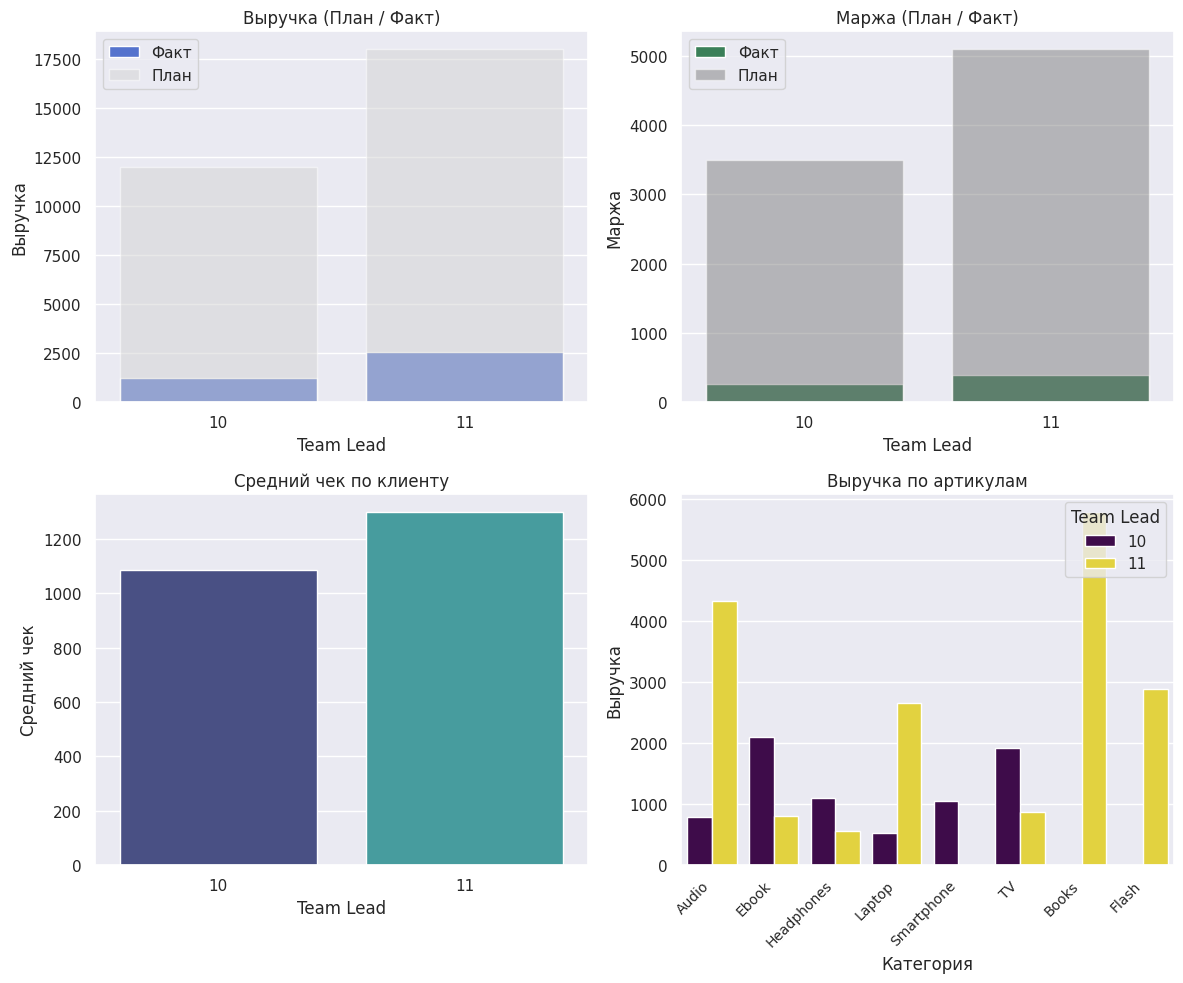

In [89]:
# Создаем фигуру с сеткой 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Выручка: План / Факт
sns.barplot(
    data=df_dash,
    x='team_lead_id',
    y='revenue_fact_x',
    color='royalblue',
    ci=None,
    ax=axes[0,0],
    label='Факт'
)
sns.barplot(
    data=df_dash,
    x='team_lead_id',
    y='plan_revenue',
    color='lightgray',
    ci=None,
    ax=axes[0,0],
    alpha=0.5,
    label='План'
)
axes[0,0].set_title('Выручка (План / Факт)')
axes[0,0].set_xlabel('Team Lead')
axes[0,0].set_ylabel('Выручка')
axes[0,0].legend()

# 2. Маржа: План / Факт
sns.barplot(
    data=df_dash,
    x='team_lead_id',
    y='margin_fact_x',
    color='seagreen',
    ci=None,
    ax=axes[0,1],
    label='Факт'
)
sns.barplot(
    data=df_dash,
    x='team_lead_id',
    y='plan_margin',
    color='gray',
    ci=None,
    ax=axes[0,1],
    alpha=0.5,
    label='План'
)
axes[0,1].set_title('Маржа (План / Факт)')
axes[0,1].set_xlabel('Team Lead')
axes[0,1].set_ylabel('Маржа')
axes[0,1].legend()

# 3. Средний чек
sns.barplot(
    data=df_dash,
    x='team_lead_id',
    y='avg_check',
    ci=None,
    palette='mako',
    ax=axes[1,0]
)
axes[1,0].set_title('Средний чек по клиенту')
axes[1,0].set_xlabel('Team Lead')
axes[1,0].set_ylabel('Средний чек')

# 4. Выручка по категориям
sns.barplot(
    data=df_dash,
    x='category',
    y='revenue_fact_x',
    hue='team_lead_id',
    ci=None,
    palette='viridis',
    ax=axes[1,1]
)
axes[1,1].set_title('Выручка по артикулам')
axes[1,1].set_xlabel('Категория')
axes[1,1].set_ylabel('Выручка')
axes[1,1].legend(title='Team Lead', loc='upper right')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()